In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mplfinance

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install tensorflow

  Using cached tensorflow-2.7.0-cp39-cp39-win_amd64.whl (430.8 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-12.0.0-2-py2.py3-none-win_amd64.whl (13.0 MB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] Det går inte att komma åt filen eftersom den

används av en annan process: 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\tensorflow\\keras\\applications\\densenet\\__init__.py'
Consider using the `--user` option or check the permissions.



  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=c406f8e67fbde98c644e935f3792d800372d170e05aeade56a14f7ef127d0157
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [19]:
#Retrieve Data and Initialize Parameters
data=web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',start,end)

crypto_currency='BTC'
against_currency='USD'

start=dt.datetime(2016,1,1)
end=dt.datetime.now()

In [40]:
#Prepare Data

data.head()

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

#we want to predict the price after 1 month (only for 1 day), having the price for the last two months
prediction_days=60
future_day=10

x_train, y_train= [],[]

for x in range(prediction_days,len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x+future_day,0])    

x_train, y_train= np.array(x_train), np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [41]:
# Create the Neural Network

# if necessary, pip install numpy==1.19.5

model=Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2)) #Prevent Overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #We just want to have one number in the end, not a bunch of different values

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train, epochs=25, batch_size=32)



Epoch 1/25
68/68 [==============================] - 10s 64ms/step - loss: 0.0108
Epoch 2/25
68/68 [==============================] - 4s 62ms/step - loss: 0.0043
Epoch 3/25
68/68 [==============================] - 4s 61ms/step - loss: 0.0047
Epoch 4/25
68/68 [==============================] - 4s 63ms/step - loss: 0.0040
Epoch 5/25
68/68 [==============================] - 4s 64ms/step - loss: 0.0038
Epoch 6/25
68/68 [==============================] - 4s 62ms/step - loss: 0.0034
Epoch 7/25
68/68 [==============================] - 4s 62ms/step - loss: 0.0035
Epoch 8/25
68/68 [==============================] - 4s 61ms/step - loss: 0.0047
Epoch 9/25
68/68 [==============================] - 4s 65ms/step - loss: 0.0036
Epoch 10/25
68/68 [==============================] - 4s 63ms/step - loss: 0.0035
Epoch 11/25
68/68 [==============================] - 4s 61ms/step - loss: 0.0030
Epoch 12/25
68/68 [==============================] - 4s 62ms/step - loss: 0.0035
Epoch 13/25
68/68 [=================

In [42]:
#Testing the Model

test_start=dt.datetime(2020,1,1)
test_end=dt.datetime.now()

test_data=web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',test_start,test_end)
actual_prices=test_data['Close'].values

#Combine the data_sets
total_dataset=pd.concat((data['Close'],test_data['Close']), axis=0)

#Model inputs for prediction
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scaler.fit_transform(model_inputs)

x_test=[]

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

#Now we have the actual prices and we want to have the predictions
prediction_prices=model.predict(x_test)
prediction_prices=scaler.inverse_transform(prediction_prices)


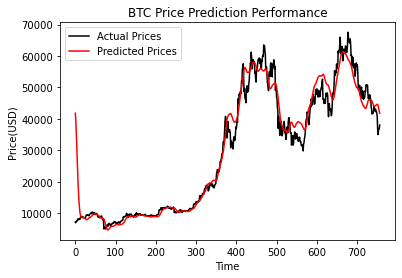

In [43]:
#Now let us visualize the predictions against actual prices

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='red', label='Predicted Prices')
plt.title(f'{crypto_currency} Price Prediction Performance')
plt.xlabel('Time')
plt.ylabel('Price(USD)')
plt.legend(loc='upper left')
plt.show()

In [46]:
git init
#git add README.md  
git add Crypto_Price_Prediction.ipynb
git commit -m "predictor commit" 
git remote add origin https://github.com/Ehsandn/Crypto_price_prediction.git
git branch -M main
git push -u origin main

SyntaxError: invalid syntax (Temp/ipykernel_6336/1101865291.py, line 1)